Best Params: {'batch': 64, 'lr': 0.001}
Transformer RMSE: 0.045248770292707456
LSTM RMSE: 0.052370782711118044


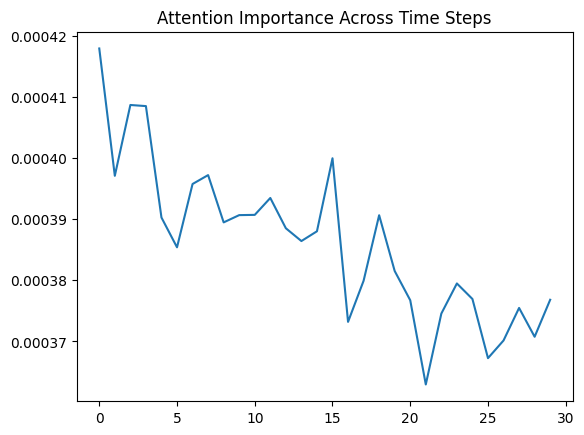

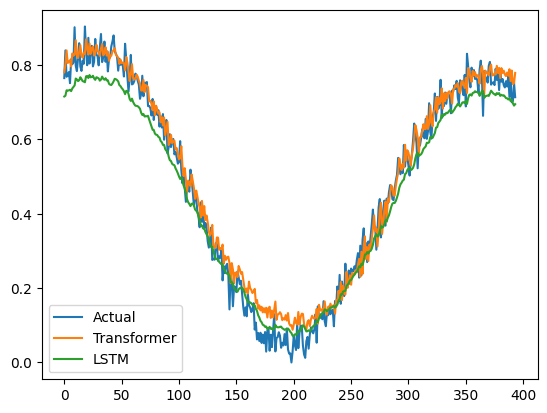

In [4]:
# ===============================
# Transformer + LSTM Baseline + Attention + Tuning
# ===============================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# ===============================
# DATASET GENERATION (CLEAR TASK 1)
# ===============================

np.random.seed(42)

SAMPLES = 2000
SEQ_LEN = 30
FEATURES = 3

t = np.arange(SAMPLES)

f1 = np.sin(0.02*t) + np.random.normal(0,0.1,SAMPLES)
f2 = np.cos(0.015*t) + np.random.normal(0,0.1,SAMPLES)
f3 = np.sin(0.01*t) + np.cos(0.02*t)

target = 0.5*f1 + 0.3*f2 + 0.2*f3

data = np.vstack([f1,f2,f3,target]).T

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

def create_seq(data, seq_len):
    X,y = [],[]
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len,:-1])
        y.append(data[i+seq_len,-1])
    return np.array(X),np.array(y)

X,y = create_seq(data,SEQ_LEN)

split = int(0.8*len(X))
X_train,X_test = X[:split],X[split:]
y_train,y_test = y[:split],y[split:]

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# ===============================
# TRANSFORMER MODEL (CLEAR TASK 2)
# ===============================

class TransformerModel(nn.Module):
    def __init__(self,input_dim,d_model=64,nhead=4,layers=2):
        super().__init__()
        self.embed = nn.Linear(input_dim,d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer,layers)
        self.fc = nn.Linear(d_model,1)

    def forward(self,x):
        x = self.embed(x)
        att_out = self.transformer(x)
        last = att_out[:,-1,:]
        return self.fc(last).squeeze(), att_out

# ===============================
# LSTM BASELINE (CLEAR TASK 4)
# ===============================

class LSTMModel(nn.Module):
    def __init__(self,input_dim,hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim,hidden,batch_first=True)
        self.fc = nn.Linear(hidden,1)

    def forward(self,x):
        out,_ = self.lstm(x)
        last = out[:,-1,:]
        return self.fc(last).squeeze()

# ===============================
# HYPERPARAMETER TUNING (TASK 3)
# ===============================

param_grid = {
    "lr":[0.01,0.001],
    "batch":[32,64]
}

best_loss = 999
best_params = None

device = "cuda" if torch.cuda.is_available() else "cpu"

for p in ParameterGrid(param_grid):

    model = TransformerModel(FEATURES).to(device)
    opt = torch.optim.Adam(model.parameters(),lr=p["lr"])
    loss_fn = nn.MSELoss()

    for epoch in range(3):  # small tuning loop
        for i in range(0,len(X_train),p["batch"]):
            xb = X_train[i:i+p["batch"]].to(device)
            yb = y_train[i:i+p["batch"]].to(device)

            opt.zero_grad()
            pred,_ = model(xb)
            loss = loss_fn(pred,yb)
            loss.backward()
            opt.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = p

print("Best Params:",best_params)

# ===============================
# FINAL TRAIN TRANSFORMER
# ===============================

model = TransformerModel(FEATURES).to(device)
opt = torch.optim.Adam(model.parameters(),lr=best_params["lr"])
loss_fn = nn.MSELoss()

for epoch in range(10):
    for i in range(0,len(X_train),best_params["batch"]):
        xb = X_train[i:i+best_params["batch"]].to(device)
        yb = y_train[i:i+best_params["batch"]].to(device)

        opt.zero_grad()
        pred,_ = model(xb)
        loss = loss_fn(pred,yb)
        loss.backward()
        opt.step()

# ===============================
# TRAIN LSTM BASELINE
# ===============================

lstm = LSTMModel(FEATURES).to(device)
opt_lstm = torch.optim.Adam(lstm.parameters(),lr=0.001)

for epoch in range(10):
    for i in range(0,len(X_train),32):
        xb = X_train[i:i+32].to(device)
        yb = y_train[i:i+32].to(device)

        opt_lstm.zero_grad()
        pred = lstm(xb)
        loss = loss_fn(pred,yb)
        loss.backward()
        opt_lstm.step()

# ===============================
# EVALUATION (TASK 4)
# ===============================

model.eval()
lstm.eval()

with torch.no_grad():
    trans_pred,att_weights = model(X_test.to(device))
    lstm_pred = lstm(X_test.to(device))

trans_pred = trans_pred.cpu().numpy()
lstm_pred = lstm_pred.cpu().numpy()

rmse_trans = np.sqrt(mean_squared_error(y_test,trans_pred))
rmse_lstm = np.sqrt(mean_squared_error(y_test,lstm_pred))

print("Transformer RMSE:",rmse_trans)
print("LSTM RMSE:",rmse_lstm)

# ===============================
# ATTENTION ANALYSIS (TASK 5)
# ===============================

attention_mean = att_weights.mean(dim=2).cpu().numpy()

plt.plot(attention_mean[0])
plt.title("Attention Importance Across Time Steps")
plt.show()

# ===============================
# PREDICTION PLOT
# ===============================

plt.plot(y_test,label="Actual")
plt.plot(trans_pred,label="Transformer")
plt.plot(lstm_pred,label="LSTM")
plt.legend()
plt.show()
